# **Parkinson Severity Classification: Outer Evaluation**

> **The next step is to make an ***estimation of the future performance*** of the best pipeline, that is, how it would work classifying the level of PD of new patients, based in their voice. This part is called ***outer evaluation***.**

## **Requirements**

In [13]:
import numpy  as np
import polars as pl
import sys
import pickle
from sklearn.neural_network import MLPClassifier
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.metrics import accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyAudio_Package_Private')
from PyAudio import get_X_audio_features

In [3]:
with open(f'results/final_best_method', 'rb') as file:
            final_best_method = pickle.load(file)

with open(f'results/final_best_stats', 'rb') as file:
        final_best_stats = pickle.load(file)

with open(f'results/final_best_model', 'rb') as file:
        final_best_model = pickle.load(file)

with open(f'results/best_params_3', 'rb') as file:
        best_params = pickle.load(file)

## **Data definition**

In [5]:
files_list_name = 'Data/Files_List.txt'
files_df = pl.read_csv(files_list_name, separator='\t', has_header=False, new_columns=['path', 'level'])

In [6]:
fs = 16000 # Sampling frequency
wst = 0.032 # Window size (seconds)
fpt = 0.008 # Frame period (seconds)
nfft = int(np.ceil(wst*fs)) # Window size (samples)
fp = int(np.ceil(fpt*fs)) # Frame period (samples)
nbands = 40 # Number of filters in the filterbank
ncomp = 20 # Number of MFCC components

In [7]:
Y = files_df['level'].to_numpy()

simple_methods = ['MFCC', 'spectral_centroid', 'chroma', 'spectral_bandwidth', 
                  'spectral_contrast', 'spectral_rolloff', 'zero_crossing_rate', 'tempogram']

combined_methods = []

stats = ['mean-std', 'median-std', 'mean-median-std', 'mean-Q25-median-Q75-std']

sizes = range(2, len(simple_methods) + 1)

combined_methods = ['-'.join(sorted(combi)) for size in sizes for combi in combinations(simple_methods, size)]

X_stats, X_stats_train, X_stats_test = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for method in simple_methods:
    for stat in stats:

        X_stats[method][stat] = get_X_audio_features(paths=files_df['path'], method=method, stats=stat, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

for method in combined_methods:
    for stat in stats:

        X_stats[method][stat] = np.column_stack([X_stats[method.split('-')[i]][stat] for i in range(0, len(method.split('-')))])

## **Outer validation method: train-test split**

In [8]:
for method in simple_methods + combined_methods:
    for stat in stats:
        X_stats_train[method][stat], X_stats_test[method][stat], Y_train, Y_test = train_test_split(X_stats[method][stat], Y, test_size=0.25, random_state=123, stratify=Y)

## **Applying Outer Evaluation**

We print the saved results in order to review which is the best pipeline, namely, the best combination of feature extraction method and model (with its hyper-parameters).

In [9]:
print(f'Best features extraction method is the combined method {final_best_method} with the statistics {final_best_stats}')
print(f'And the best model is {final_best_model} with the following hyper-parameters:\n{best_params[final_best_method][final_best_stats][final_best_model]}')

Best features extraction method is the combined method MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate with the statistics mean-Q25-median-Q75-std
And the best model is MLP with the following hyper-parameters:
{'learning_rate_init': 0.0007230035617449583, 'alpha': 0.0015684955983016854, 'activation': 'logistic', 'hidden_layer_sizes': 300, 'max_iter': 300}


- Estimation of future performance based on the testing partition:

In [ ]:
MLP_model = MLPClassifier(random_state=123).set_params(**best_params[final_best_method][final_best_stats][final_best_model])
MLP_model.fit(X=X_stats_train[final_best_method][final_best_stats], y=Y_train)
Y_test_hat = MLP_model.predict(X=X_stats_test[final_best_method][final_best_stats])
future_performance_balanced_acc = balanced_accuracy_score(y_pred=Y_test_hat, y_true=Y_test)
future_performance_acc = accuracy_score(y_pred=Y_test_hat, y_true=Y_test)

In [11]:
print(f'The estimation of future performance of the best pipeline in terms of balanced accuracy is {int(np.round(future_performance_balanced_acc, 2)*100)}%, and in terms of accuracy is {int(np.round(future_performance_acc, 2)*100)}%.')

The estimation of future performance of the best pipeline in terms of balanced accuracy is 83%, and in terms of accuracy is 85%.


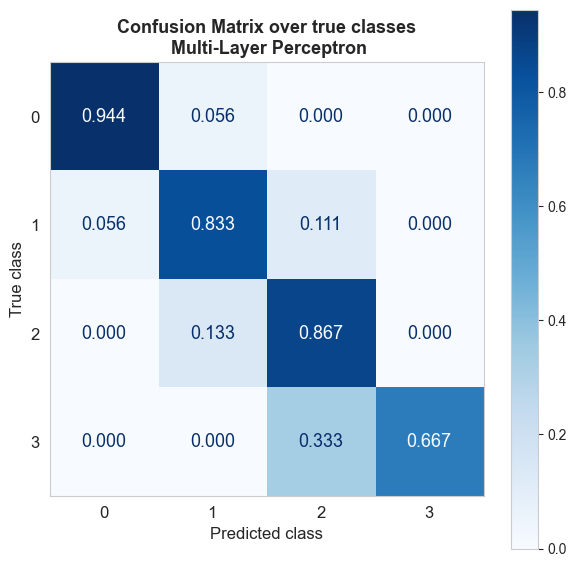

In [14]:
cm = confusion_matrix(y_pred=Y_test_hat, y_true=Y_test, normalize='true', labels=MLP_model.classes_)
# normalize='true' to normalize over the rows (true classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MLP_model.classes_)

fig, axs = plt.subplots(figsize=(7,7))
disp.plot(ax=axs, cmap=plt.cm.Blues, values_format='.3f', text_kw={'fontsize': 13})
plt.title('Confusion Matrix over true classes\n Multi-Layer Perceptron', weight='bold', fontsize=13)
axs.set_xlabel('Predicted class', size=12)
axs.set_ylabel('True class', size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()

The results of the confusion matrix are generally good, these results were expected based on the estimation of future performance. The errors made by the model are localized, there are no major confusions. The error is always one level.

The class that produces the biggest error is class 3 (severe level), it seems that the model does not recognize this class too well, something that may be due to an unbalance of this class, there are fewer samples of this class so the model maybe does not capture the characteristics that differentiate this class from class 2. With some kind of class balancing or weights, the accuracy in that class could be increased if necessary.